In [0]:
import pandas as pd
import numpy as np
import gc
from scipy import sparse
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from pandas import read_csv

In [0]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, Conv1D, MaxPooling1D
from keras import losses
from sklearn.metrics import r2_score
from tensorflow.keras import activations
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Define a model
losses.custom_loss = root_mean_squared_error
batch_size = 128

model = Sequential()

model.add(Conv1D(16, 5, input_shape=(1000, 5)))
model.add(Activation(activations.relu))
model.add(MaxPooling1D(5))

model.add(Conv1D(16, 5))
model.add(Activation(activations.relu))
model.add(MaxPooling1D(5))

model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1000))

model.compile('adam', losses.custom_loss, metrics=['accuracy', 'mean_squared_error', 'logcosh'])

Using TensorFlow backend.


In [0]:
# Applies model for all 4/5 folds, trains ans saves result
for i in range(5):
  X_train = np.array([])
  y_train = np.array([])
  for j in range(5):
    if i != j:
      data_feat = np.array(sparse.csr_matrix.todense(sparse.load_npz("folds/folds_feat_{j}.npz".format(j=j)))).reshape(-1, 1000, 5)
      if ((X_train).shape[0] == 0):
        X_train = data_feat
      else:
        X_train = np.concatenate((X_train, data_feat), axis=0)
      
      data_target = np.array(sparse.csr_matrix.todense(sparse.load_npz("folds/folds_target_{j}.npz".format(j=j))))
      if ((y_train).shape[0] == 0):
        y_train = data_target
      else:
        y_train = np.concatenate((y_train, data_target), axis=0)

  model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=30, verbose=1)
  model.save('folds/model_{i}'.format(i=i))

/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:248: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


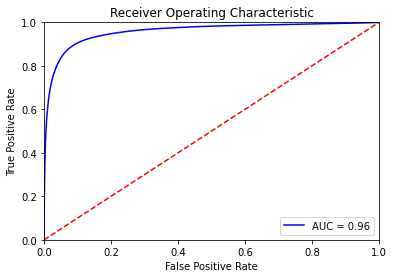

In [0]:
# Plots ROC function
X_test = np.array(sparse.csr_matrix.todense(sparse.load_npz("folds/folds_feat_{j}.npz".format(j=0)))).reshape(-1, 1000, 5)
y_test = np.array(sparse.csr_matrix.todense(sparse.load_npz("folds/folds_target_{j}.npz".format(j=0))))
y_test_binary = y_test >= 0.35
probs = model.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test_binary.flatten(), probs.flatten())
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()